In [1]:
import ta
import yfinance as yf
import pandas as pd
import numpy as np
import datetime

In [2]:
# Set the end date to today
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

# Calculate the start date as one year ago from today
start_date = (datetime.datetime.today() - datetime.timedelta(days=365)).strftime('%Y-%m-%d')


data = yf.download('TCS.NS', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [3]:
# Download data for TCS for the last year
#data = yf.download('TCS.NS', start=start_date, end=end_date)

In [4]:
data['EMA9'] = data['Close'].ewm(span=9, adjust=False).mean()
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['EMA50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA100'] = data['Close'].ewm(span=100, adjust=False).mean()
data['EMA200'] = data['Close'].ewm(span=200, adjust=False).mean()

# Compute the 20 day average volume
data['VolumeAvg20'] = data['Volume'].rolling(window=20).mean()

In [5]:
data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()

In [25]:
macd = ta.trend.MACD(data['Close'], window_fast=12, window_slow=26, window_sign=9)
data['MACD'] = macd.macd()
data['MACD_signal'] = macd.macd_signal()
data['MACD Above Signal'] = data['MACD'] > data['MACD_signal']


In [ ]:
data.tail()


In [26]:
df = pd.DataFrame(data)

In [ ]:
# Assuming you have a DataFrame named 'df' with columns EMA9, EMA20, EMA50, EMA100, EMA200
# We will create two new columns 'signal' and 'positions' to keep track of buy/sell signals and positions

# Initialize the columns with zeros
df['signal'] = 0
df['positions'] = 0

# Find where the EMA9 crosses above EMA20 and set signal to 1
# This is the bullish crossover signal
df['signal'][9:] = np.where(df['EMA9'][9:] > df['EMA20'][9:], 1, 0)

# Take the difference of the signal between consecutive rows
# This will help us identify when the signal changes from 1 to 0 or 0 to 1
df['positions'] = df['signal'].diff()

# Initialize a variable to keep track of the current position
current_position = 0

# Loop through each row and execute trades based on the position
for i, row in df.iterrows():
    if row['positions'] == 1:
        # If the signal changes from 0 to 1, buy 100 shares
        current_position = 100
    elif row['positions'] == -1:
        # If the signal changes from 1 to 0, sell 100 shares
        current_position = -100
    else:
        # If there is no change in signal, hold the current position
        pass

    # Update the positions column with the current position
    df.at[i, 'positions'] = current_position

# Plot the positions column to visualize the trades
df['positions'].plot()


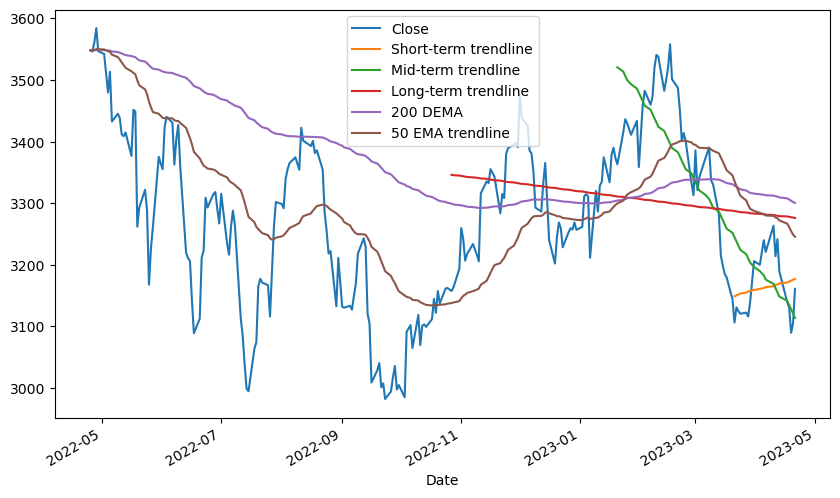

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assuming you have a pandas DataFrame named 'data' with columns 'Date' and 'Price'

# Convert the 'Date' column to a datetime object and set it as the index
#data['Date'] = pd.to_datetime(data['Date'])
#df.set_index('Date', inplace=True)

# Define a function to calculate the slope and y-intercept of a trendline
def calculate_trendline(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope * x + intercept

# Define the time periods for each trendline
short_term_period = 20
mid_term_period = 60
long_term_period = 120

# Calculate the short-term trendline using linear regression
short_term_trendline = calculate_trendline(np.arange(len(df['Close']))[-short_term_period:], df['Close'][-short_term_period:])

# Calculate the mid-term trendline using linear regression
mid_term_trendline = calculate_trendline(np.arange(len(df['Close']))[-mid_term_period:], df['Close'][-mid_term_period:])

# Calculate the long-term trendline using linear regression
long_term_trendline = calculate_trendline(np.arange(len(df['Close']))[-long_term_period:], df['Close'][-long_term_period:])

# Plot the price data and trendlines
fig, ax = plt.subplots(figsize=(10, 6))

df['Close'].plot(ax=ax, label='Close')
ax.plot(df.index[-short_term_period:], short_term_trendline, label='Short-term trendline')
ax.plot(df.index[-mid_term_period:], mid_term_trendline, label='Mid-term trendline')
ax.plot(df.index[-long_term_period:], long_term_trendline, label='Long-term trendline')
ax.plot( df['EMA200'].index , df['EMA200'] , label='200 DEMA')
ax.plot( df['EMA50'].index , df['EMA50'] , label='50 EMA trendline')

ax.legend()
plt.show()


In [48]:
ax.plot( df['EMA200'].index , df['EMA200'] , label='200 EMA trendline')

In [49]:
ax.legend()
plt.show()

In [47]:
df['EMA200']


Date
2022-04-25    3548.199951
2022-04-26    3548.181047
2022-04-27    3548.310588
2022-04-28    3548.668692
2022-04-29    3548.649103
                 ...     
2023-04-17    3307.744088
2023-04-18    3305.982952
2023-04-19    3303.829889
2023-04-20    3301.849493
2023-04-21    3300.446514
Name: EMA200, Length: 247, dtype: float64

In [16]:
df.iloc[-1, :]

Open           3.110000e+03
High           3.164450e+03
Low            3.100800e+03
Close          3.160850e+03
Adj Close      3.160850e+03
Volume         1.929184e+06
EMA9           3.153518e+03
EMA20          3.181221e+03
EMA50          3.245394e+03
EMA100         3.276572e+03
EMA200         3.300447e+03
VolumeAvg20    2.269283e+06
RSI            4.530224e+01
Name: 2023-04-21 00:00:00, dtype: float64

In [17]:
last_row = df.iloc[-1, :]
last_row_df = last_row.to_frame().T

In [23]:
last_row_df["% change volume"] = ((last_row_df ["VolumeAvg20"] - last_row_df ["Volume"]) * 100) / last_row_df ["Volume"]

In [24]:
last_row_df

,Open,High,Low,Close,Adj Close,Volume,EMA9,EMA20,EMA50,EMA100,EMA200,VolumeAvg20,RSI,% chnage volume,% change volume
2023-04-21,3110.0,3164.449951,3100.800049,3160.850098,3160.850098,1929184.0,3153.518328,3181.221394,3245.393822,3276.572467,3300.446514,2269283.2,45.302236,17.629174,17.629174


In [ ]:
#!/usr/bin/env python
# coding: utf-8

import ta
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.stats import linregress


class Stock:

    def __init__(self, name='', interval=365):
        self.ticker = name
        self.data = None
        self.start_date = (datetime.datetime.today() -
                           datetime.timedelta(days=interval)).strftime('%Y-%m-%d')
        self.end_date = datetime.datetime.today().strftime('%Y-%m-%d')
        self.df = None
        self.short_term_period = None
        self.mid_term_period = None
        self.long_term_period = None

    def get_data(self):
        self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        self.df = pd.DataFrame(self.data)

    def show_data(self, period=1):
        return self.df.tail(period).T.apply(lambda x: "{:,.2f}".format(x)).astype(str)

    def calculate_technical_indicators(stock, ema_span=9, ema_span_list=None, rsi_window=14, macd_fast=12,
                                       macd_slow=26, macd_signal=9):
        if ema_span_list is None:
            ema_span_list = [20, 50, 100, 200]
        stock.df['EMA{}'.format(ema_span)] = stock.df['Close'].ewm(span=ema_span, adjust=False).mean()
        for span in ema_span_list:
            stock.df['EMA{}'.format(span)] = stock.df['Close'].ewm(span=span, adjust=False).mean()
        stock.df['VolumeAvg20'] = stock.df['Volume'].rolling(window=20).mean()
        stock.df['RSI'] = ta.momentum.RSIIndicator(stock.df['Close'], window=rsi_window).rsi()
        macd = ta.trend.MACD(stock.df['Close'], window_fast=macd_fast, window_slow=macd_slow, window_sign=macd_signal)
        stock.df['MACD'] = macd.macd()
        stock.df['MACD_signal'] = macd.macd_signal()
        stock.df['MACD Above Signal'] = stock.df['MACD'] > stock.df['MACD_signal']

    # Define a function to calculate the slope and y-intercept of a trendline

    def set_period_values(self, st=10, mt=50, lt=100):
        self.short_term_period = st
        self.mid_term_period = mt
        self.long_term_period = lt

    def trendline(self):
        def trend_data(x, y):
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            return slope * x + intercept

        def calculate_trendline(df, period):
            return trend_data(np.arange(len(df['Close']))[-period:], df['Close'][-period:])

        self.short_term_trendline = calculate_trendline(self.df, self.short_term_period)
        self.mid_term_trendline = calculate_trendline(self.df, self.mid_term_period)
        self.long_term_trendline = calculate_trendline(self.df, self.long_term_period)

    # Calculate the short-term trendline using linear regression

    # # Calculate the mid-term trendline using linear regression
    # mid_term_trendline = calculate_trendline(np.arange(len(df['Close']))[-mid_term_period:], df['Close'][-mid_term_period:])

    # # Calculate the long-term trendline using linear regression
    # long_term_trendline = calculate_trendline(np.arange(len(df['Close']))[-long_term_period:], df['Close'][-long_term_period:])

    # # Plot the price data and trendlines
    def plot_trends(self):
        # if self.short_term_trendline == None:
        #     trendline()

        fig, ax = plt.subplots(figsize=(10, 6))

        self.df['Close'].plot(ax=ax, label='Close')
        ax.plot(self.df.index[-self.short_term_period:], self.short_term_trendline, label='Short-term trendline')
        ax.plot(self.df.index[-self.mid_term_period:], self.mid_term_trendline, label='Mid-term trendline')
        ax.plot(self.df.index[-self.long_term_period:], self.long_term_trendline, label='Long-term trendline')

        ax.legend()
        plt.savefig('plot.png', dpi=300, bbox_inches='tight')
        # plt.show()






In [3]:
 tcs = Stock('TCS.NS')

#    tcs.set_period_values()
#    tcs.trendline()
#    tcs.plot_trends()



In [8]:

tcs.get_data()

[*********************100%***********************]  1 of 1 completed


In [9]:
tcs.data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-26,3575.149902,3587.899902,3518.149902,3546.300049,3434.654297,1943469
2022-04-27,3546.000000,3568.449951,3506.300049,3561.199951,3449.085205,1727648
2022-04-28,3588.000000,3604.399902,3538.050049,3584.300049,3471.458008,1703660
2022-04-29,3597.000000,3623.250000,3536.850098,3546.699951,3435.041504,2051115
2022-05-02,3519.899902,3547.949951,3492.750000,3542.399902,3430.876953,1324161
...,...,...,...,...,...,...
2023-04-19,3130.750000,3140.000000,3071.500000,3089.600098,3089.600098,3298034
2023-04-20,3090.000000,3113.000000,3078.000000,3104.800049,3104.800049,2419999
2023-04-21,3110.000000,3164.449951,3100.800049,3160.850098,3160.850098,1929184


In [21]:
tcs.df.tail(1).T.apply(lambda x: round(x, 2))

Date,2023-04-25
Open,3183.0
High,3191.2
Low,3147.5
Close,3176.0
Adj Close,3176.0
Volume,2023886.0


In [4]:
import yfinance as yf

# Get a list of all tickers available on Yahoo Finance
tickers = yf.Tickers('')

# Loop through each ticker and print the ticker symbol and company name
for ticker in tickers.tickers:
    info = ticker.info
    print(info['symbol'], '-', info['longName'])


In [8]:
tickers.tickers

{}